# Conceptual Saliency

Welcome to the **Conceptual Saliency** notebook! This project aims to apply Formal Concept Analysis (FCA) algorithms to a dataset and analyse the resulting visualizations using saliency mapping techniques.

## Overview

Formal Concept Analysis (FCA) is a mathematical technique used for data analysis, knowledge representation, and information retrieval. By using FCA, we can extract meaningful patterns and relationships from complex datasets. Saliency mapping, on the other hand, helps in identifying the most significant parts of a visualisation, aiding in better interpretation and insights.

## Reference Libraries

- For Formal Concept Analysis: [https://github.com/EgorDudyrev/FCApy](https://github.com/EgorDudyrev/FCApy) a python package to work with Formal Concept Analysis.
- For Saliency mapping: [https://github.com/pair-code/saliency](https://github.com/pair-code/saliency)

## Reference Datasets

The Tate Collection: [https://github.com/tategallery/collection](https://github.com/tategallery/collection) starting from some pre-processed data already available here [https://github.com/SPARQL-Anything/showcase-tate](https://github.com/SPARQL-Anything/showcase-tate) 

## Data Preparation

In order to apply FCA methods, the library needs a matrix as input, such as this one

In [ ]:
'''
,fly,hunt,run,swim
dove,True,False,False,False
hen,False,False,False,False
duck,True,False,False,True
goose,True,False,False,True
owl,True,True,False,False
hawk,True,True,False,False
eagle,True,True,False,False
fox,False,True,True,False
dog,False,False,True,False
wolf,False,True,True,False
cat,False,True,True,False
tiger,False,True,True,False
lion,False,True,True,False
horse,False,False,True,False
zebra,False,False,True,False
cow,False,False,False,False
'''

I will create a binary matrix `artworkId x subjectName` starting from subjects.csv and subjects-artworks-id.csv files available [here](https://github.com/SPARQL-Anything/showcase-tate).
Namely,

In [ ]:
# subjects.csv
'''
subjectId,subjectName
,
1,subject
4,group/movement
13,architecture
14,agricultural
15,bridges and viaducts
17,features
18,garden structures
19,industrial
20,military
21,monuments
22,periods and styles
23,places of entertainment
24,public and municipal
25,religious
26,residential
...
'''

# subjects-artworks-id.csv
'''
subjectId,artworkId
25,5700
13,5748
4537,8416
92,15718
1519,23478
29,15699
166,105988
92,10108
78,7214
91,23699
14439,20199
...
'''

I will:
1. **Load the CSV files** into data frames.
2. Based on lavel two of the subject hierarchy, **substitute** the `subjectId` in `subjects-artworks-id.csv` dataframe with the closest parent.
3. **Merge** the modified dataframe with the `subjects.csv` dataframe on the `subjectId` to get the corresponding `subjectName`.
4. **Create the binary matrix** with `artworkId` as rows and `subjectName` as columns, with True or False values.

In [1]:
# %pip install fcapy
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
import os
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\giuli\Desktop\conceptual-saliency\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Subjects are organised in a hierarchy. We first decided on the level of depth to use (see `subject_hierarchy.ipynb`). Now we substitute all subjects that go deeper than that with their closest parent.

In [2]:
# load subjects-artworks relationships
subjects_artworks_df = pd.read_csv('https://raw.githubusercontent.com/SPARQL-Anything/showcase-tate/main/subjects-artworks-id.csv')
print(subjects_artworks_df)

        subjectId  artworkId
0              25       5700
1              13       5748
2            4537       8416
3              92      15718
4            1519      23478
...           ...        ...
839427         22       6267
839428        106      46310
839429        145      46866
839430        496       7098
839431        189       2325

[839432 rows x 2 columns]


Keep only `substituted_subjectId` column and rename it

In [3]:
# load subjects
subjects_df = pd.read_csv('https://raw.githubusercontent.com/SPARQL-Anything/showcase-tate/main/subjects.csv')

# Merge the filtered dataframe with the subjects dataframe on subjectId
merged_df = pd.merge(subjects_artworks_df, subjects_df, on='subjectId')

# Display the final dataframe
print(len(merged_df))
print(merged_df)

subjects = len(pd.unique(merged_df['subjectName']))
print(subjects)

839432
        subjectId  artworkId                    subjectName
0              25       5700                      religious
1              13       5748                   architecture
2            4537       8416                    art gallery
3              92      15718  actions: postures and motions
4            1519      23478                          beach
...           ...        ...                            ...
839427         22       6267             periods and styles
839428        106      46310                         places
839429        145      46866                        society
839430        496       7098                         wooded
839431        189       2325      from recognisable sources

[839432 rows x 3 columns]
16232


In [4]:
# create the binary matrix with True/False values

# ensure the data directory exists
data_dir = '../data'
output_file_path = os.path.join(data_dir, 'full_artwork_subject_binary_matrix.csv')

# Set artworkId as the index for merged_df
merged_df.set_index('artworkId', inplace=True)
# Create a pivot table with artworkId as rows and subjectName as columns
pivot_df = merged_df.pivot_table(index='artworkId', columns='subjectName', aggfunc=lambda x: True, fill_value=False)

# Drop the 'subjectId' level from the columns
pivot_df.columns = pivot_df.columns.droplevel()
pivot_df.index.name = None

# Display the final pivot table
print(pivot_df)

# Save the pivot_df as a CSV file
pivot_df.to_csv(output_file_path)

subjectName  'A Midsummer Night's Dream'  'Altar of Augustus', sculpture  \
3                                  False                           False   
4                                  False                           False   
5                                  False                           False   
7                                  False                           False   
8                                  False                           False   
...                                  ...                             ...   
127129                             False                           False   
127130                             False                           False   
127131                             False                           False   
127717                             False                           False   
129068                             False                           False   

subjectName  'Altar of Hercules', sculpture  'Antony and Cleopatra'  \
3               

## Formal Context

In [2]:
data_dir = '../data'
input_file_path = os.path.join(data_dir, 'full_artwork_subject_binary_matrix.csv')
output_file_path = os.path.join(data_dir, 'full_artwork_subject_context.csv')
# load the CSV file and ensure the index (artworkId) is of type str
df = pd.read_csv(input_file_path, index_col=0)
df.index = df.index.map(str)

# Create the FormalContext
K = FormalContext.from_pandas(df)
K.write_csv(output_file_path, sep=',')


# Print the first five objects data
print(len(K))
print('# objects', K.n_objects, '; # attributes', K.n_attributes)
print(K[:5])

58800
# objects 58800 ; # attributes 160
FormalContext (5 objects, 160 attributes, 42 connections)
 |21st century|Bible: New Testament|Bible: Old Testament|Judaeo-Christian imagery|Saints|...|weapons|weather|work and occupations|workspaces|world religions|
3|            |                    |                    |                        |      |...|       |       |                    |          |               |
4|            |                    |                    |                        |      |...|       |      X|                    |          |               |
5|            |                    |                    |                        |      |...|       |       |                   X|          |               |
7|            |                    |                    |                        |      |...|       |       |                    |          |               |
8|            |                    |                    |                        |      |...|       |       |  

## Concept Lattice

In [3]:
output_lattice_file = os.path.join(data_dir, 'full_artwork_subject_concept.json')
# create the concept lattice
L = ConceptLattice.from_context(K, algo='Sofia', L_max = 1000, min_supp = 0.1, use_tqdm=True)
L.write_json(objs_order=K.object_names, attrs_order=K.attribute_names, path=output_lattice_file)
print("# concepts:", len(L))

Iter. Sofia projections: 100%|██████████| 160/160 [00:00<00:00, 360.25it/s]


# concepts: 87


In [4]:
intent_set = set()
for i, c in enumerate(L):
    print(f"Concept {i} {c.intent}:\nextent {len(c.extent)}\nintent {len(c.intent)}\n")
    intent_set.add(len(c.intent))

Concept 0 ():
extent 58800
intent 0

Concept 1 ('nature',):
extent 36486
intent 1

Concept 2 ('architecture',):
extent 29787
intent 1

Concept 3 ('places',):
extent 23842
intent 1

Concept 4 ('landscape', 'nature'):
extent 23323
intent 2

Concept 5 ('architecture', 'nature'):
extent 22715
intent 2

Concept 6 ('people',):
extent 20800
intent 1

Concept 7 ('adults', 'people'):
extent 19158
intent 2

Concept 8 ('nature', 'places'):
extent 18709
intent 2

Concept 9 ('architecture', 'places'):
extent 18618
intent 2

Concept 10 ('architecture', 'townscapes, man-made features'):
extent 18499
intent 2

Concept 11 ('architecture', 'landscape', 'nature'):
extent 15963
intent 3

Concept 12 ('architecture', 'nature', 'places'):
extent 14589
intent 3

Concept 13 ('architecture', 'nature', 'townscapes, man-made features'):
extent 14470
intent 3

Concept 14 ('society',):
extent 14011
intent 1

Concept 15 ('landscape', 'nature', 'places'):
extent 13186
intent 3

Concept 16 ('objects',):
extent 12381
i

In [10]:
temp_list = list(intent_set)
temp_list.pop()
intent_unique_values = set(temp_list)

### Visualisation

In [10]:
figsize = (10, 10)

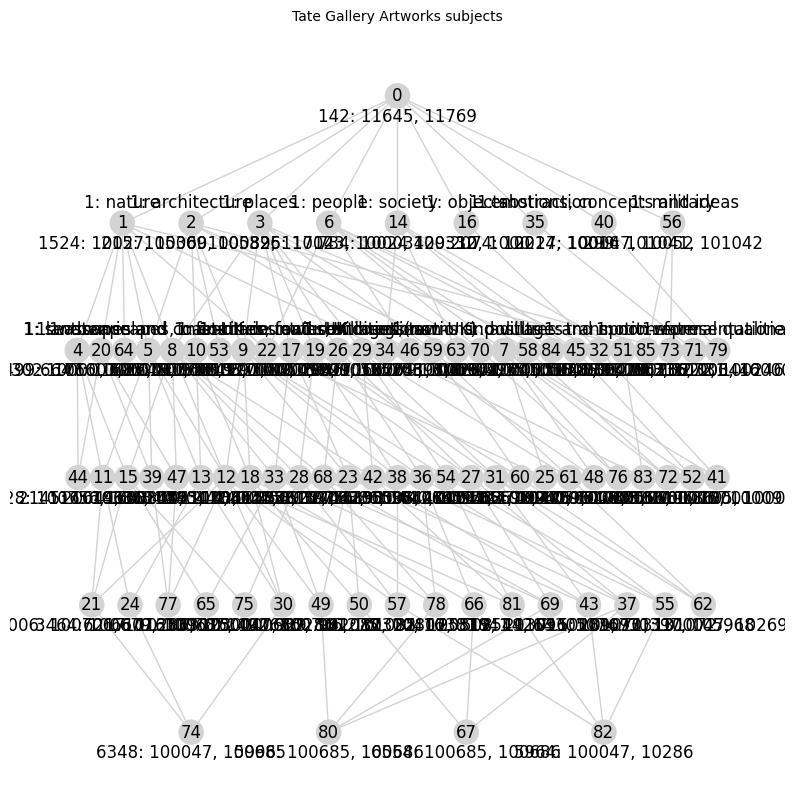

In [60]:
fig, ax = plt.subplots(figsize=figsize)
vsl = LineVizNx()
vsl.draw_concept_lattice(L, ax=ax, flg_drop_bottom_concept=True, flg_node_indices=True)
ax.set_title('Tate Gallery Artworks subjects', fontsize=10)
plt.show()
plt.close()

In [13]:
# Normalize the values to a range between 0 and 1
min_val = min(intent_unique_values)
max_val = max(intent_unique_values)
normalized_values = [(val - min_val) / (max_val - min_val) for val in intent_unique_values]

# Adjust the range to avoid pure black
def adjust_to_avoid_black(norm_val):
    return 0.0 + 0.6 * norm_val  # Adjusting the range to be from white to 60% gray

adjusted_values = [adjust_to_avoid_black(val) for val in normalized_values]

# Create a dictionary mapping each number to a corresponding gray intensity
gray_map = {val: f"#{int((1 - adj_val) * 255):02x}{int((1 - adj_val) * 255):02x}{int((1 - adj_val) * 255):02x}" for val, adj_val in zip(intent_unique_values, adjusted_values)}

print(gray_map)

{0: '#ffffff', 1: '#e0e0e0', 2: '#c1c1c1', 3: '#a3a3a3', 4: '#848484', 5: '#666666'}


In [14]:
from copy import deepcopy
L_clr = deepcopy(L)

# color
node_color = []
extent_intensity = []
for c in L_clr:
    if len(c.extent) != 0:
        color = gray_map[len(c.intent)]
        node_color.append(color)
        extent_len = len(c.extent)
        extent_intensity.append(extent_len)

print('COLORS: ', node_color)
print('SIZE: ', extent_intensity)

COLORS:  ['#ffffff', '#e0e0e0', '#e0e0e0', '#e0e0e0', '#c1c1c1', '#c1c1c1', '#e0e0e0', '#c1c1c1', '#c1c1c1', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#a3a3a3', '#e0e0e0', '#a3a3a3', '#e0e0e0', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#c1c1c1', '#848484', '#c1c1c1', '#a3a3a3', '#848484', '#a3a3a3', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#c1c1c1', '#848484', '#a3a3a3', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#e0e0e0', '#a3a3a3', '#848484', '#a3a3a3', '#a3a3a3', '#e0e0e0', '#a3a3a3', '#a3a3a3', '#848484', '#a3a3a3', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#848484', '#848484', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#a3a3a3', '#848484', '#e0e0e0', '#848484', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#848484', '#c1c1c1', '#c1c1c1', '#848484', '#848484', '#666666', '#a3a3a3', '#848484', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#666666', '#848484', '#a3a3a3', '#848484', '#848484', '#c1c1c1', '#666666', '#848484', '#666666', '#a3a3a3', '#c1c1c1', '#c1c1c1']
SIZE:  [58800, 36486, 29787, 23842, 23323, 2

In [69]:
# size
# Normalize the values to a range between min_size and max_size
min_val = min(extent_intensity)
max_val = max(extent_intensity)

# Avoid division by zero if all values are the same
if max_val != min_val:
    normalized_values = [(val - min_val) / (max_val - min_val) for val in extent_intensity]
else:
    normalized_values = [0.5] * len(extent_intensity)  # If all values are the same, set them to the midpoint size

node_sizes = [min_val + norm_val * (max_val - min_val) for norm_val in normalized_values]

In [204]:
fig, ax = plt.subplots(figsize=(80,80))
vsl.draw_concept_lattice(L_clr, ax=ax, flg_node_indices=True, node_label_func=None,
    flg_new_intent_count_prefix=True, flg_drop_bottom_concept=True, node_color='#e0e0e0', node_size=node_sizes, edge_size=10, edge_color='#a3a3a3', fontsize=500)
plt.savefig('../results/lattice/to_compare.png')
plt.close()
# colour: number of attributes (white=0)
# size: number of subjects (the smaller the lesser)

In [136]:
fig, ax = plt.subplots(figsize=(80,80))
vsl.draw_concept_lattice(L_clr, ax=ax, flg_node_indices=False, node_label_func=None,
    flg_new_intent_count_prefix=False, flg_drop_bottom_concept=True, node_color=node_color, node_size=node_sizes, edge_size=10, edge_color='#e0e0e0')
plt.savefig('../results/lattice/to_process.png')
plt.close()


### Scatterplot Extent-X, Intent-Y

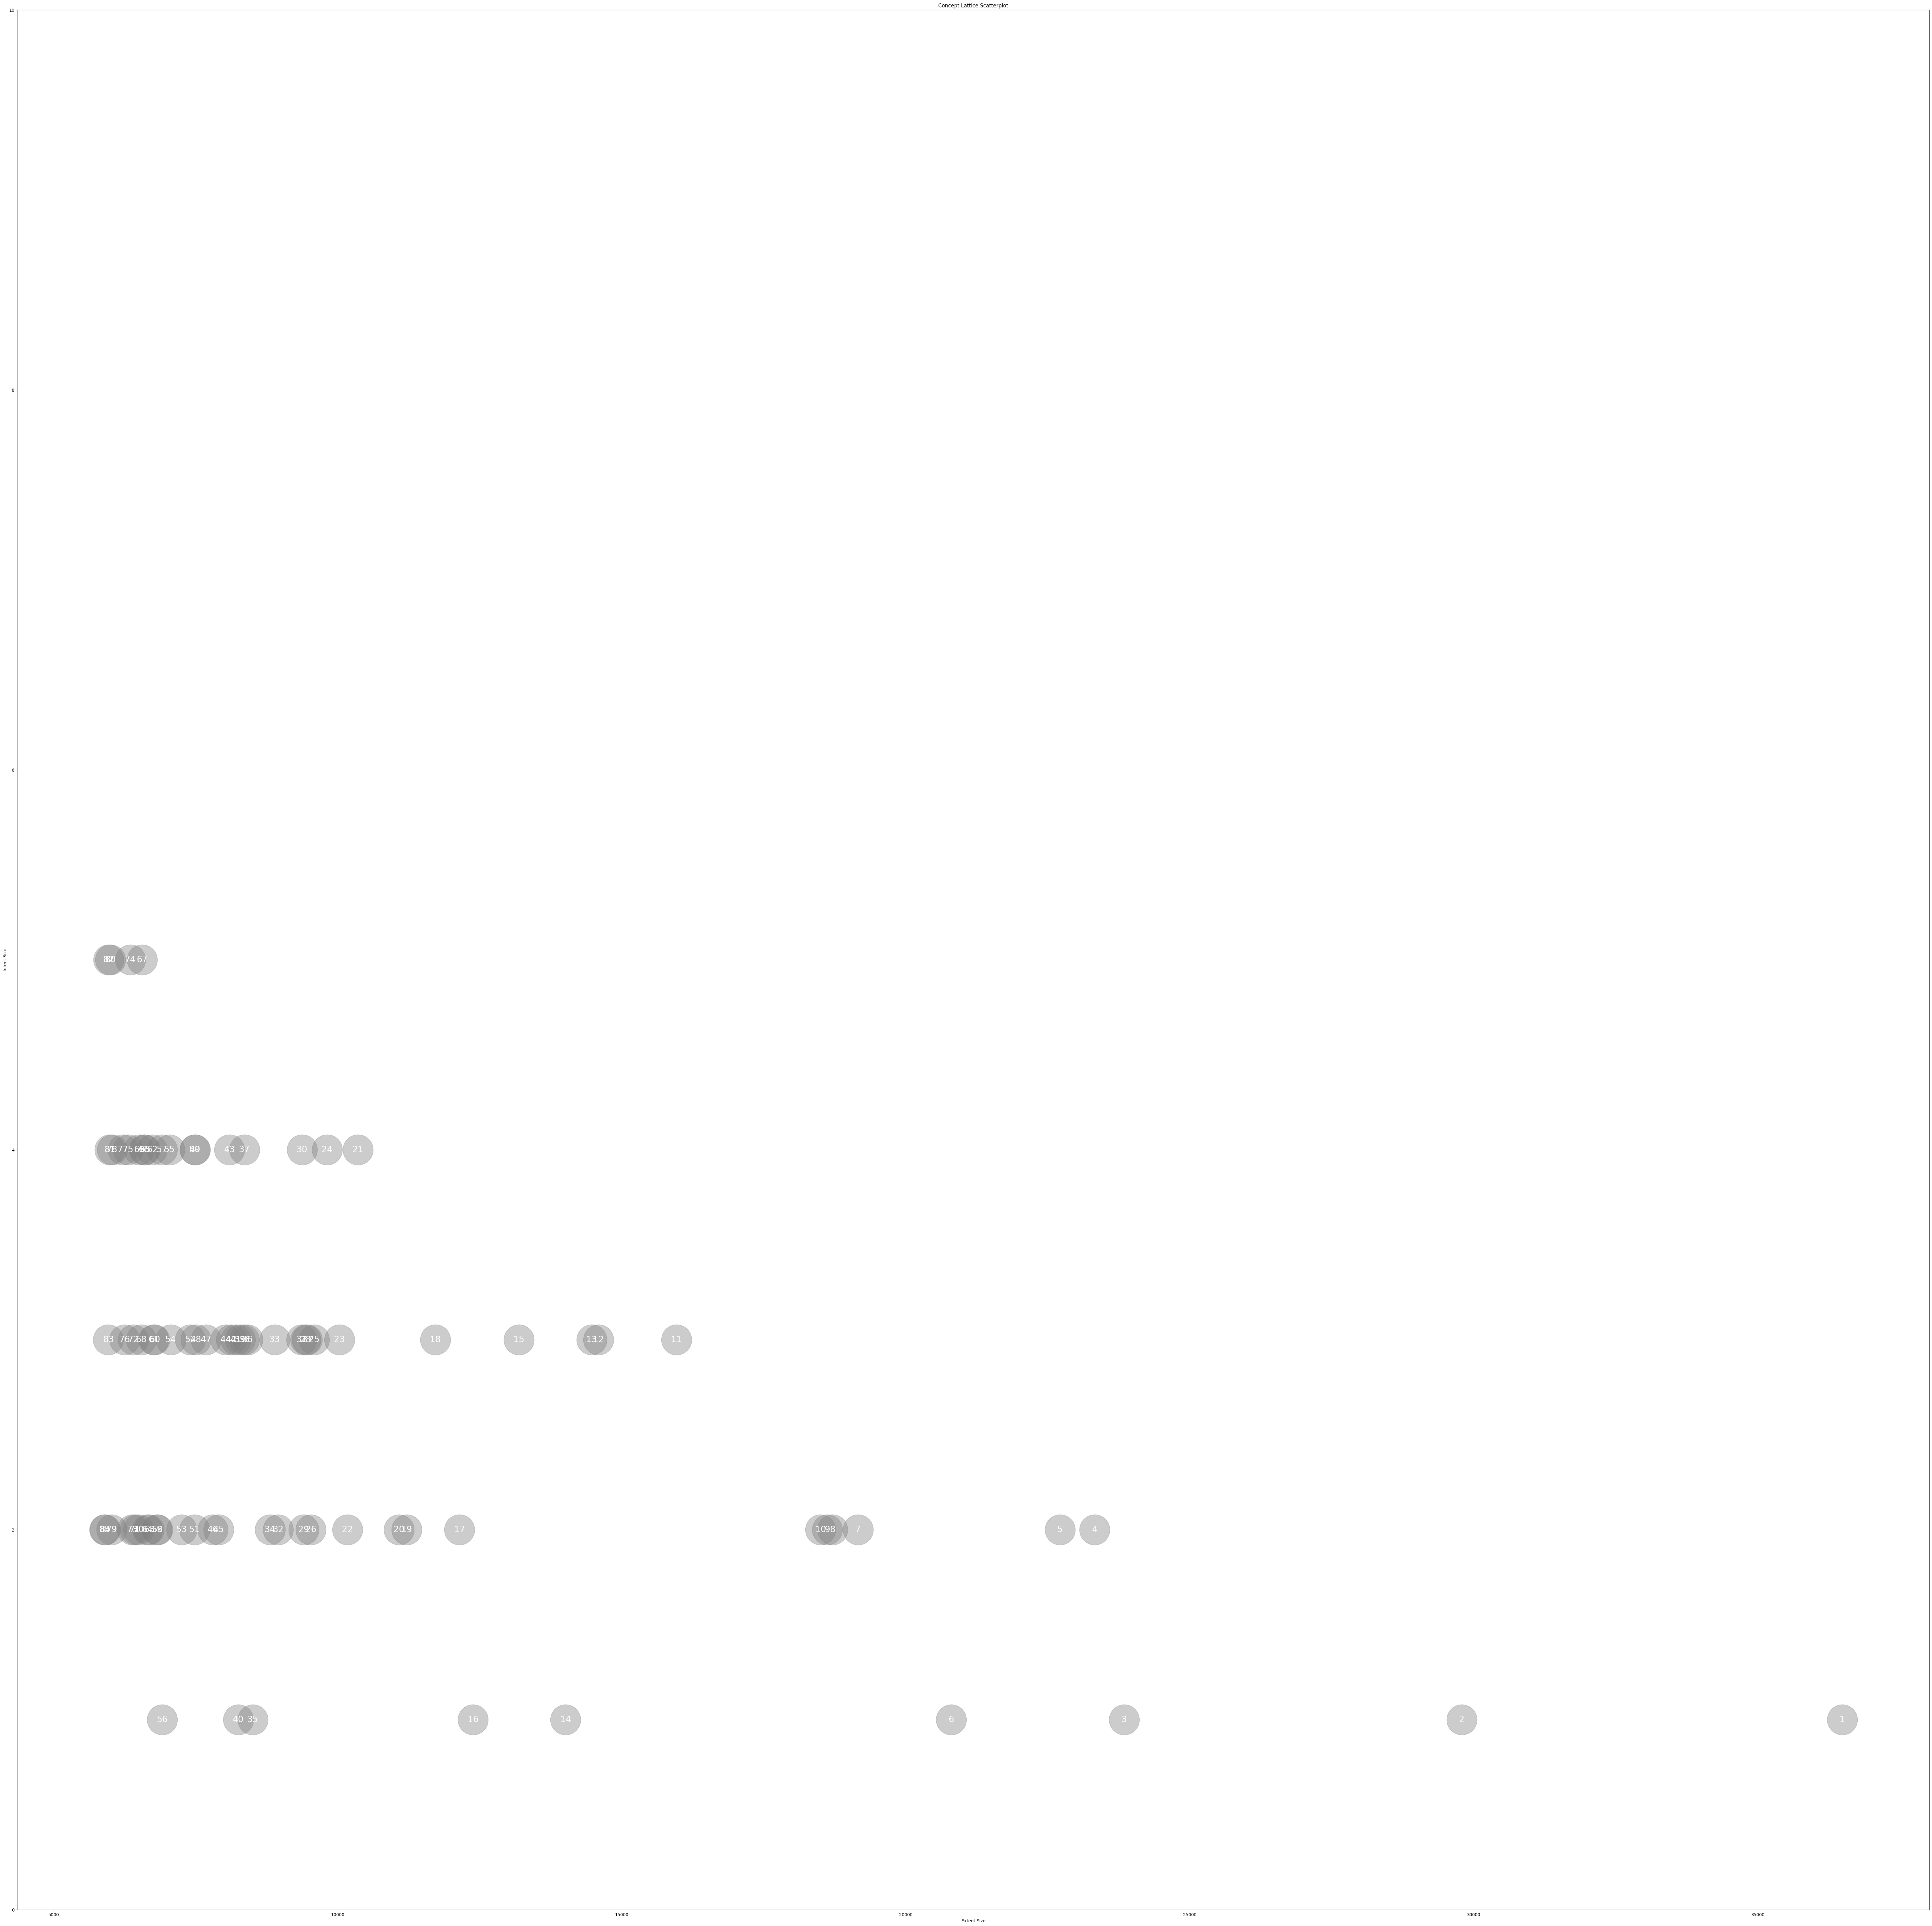

In [176]:
# Plotting the concept lattice as a scatterplot
# Extract concepts and assign coordinates (for simplicity, we'll use their index as coordinates)
# concepts = [(i, len(concept.extent), len(concept.intent)) for i, concept in enumerate(L)]
# if we don't want intent/extent = 0
concepts = [(i, len(concept.extent), len(concept.intent)) for i, concept in enumerate(L) if len(concept.extent) != 0 and len(concept.intent) != 0]

# Separate the coordinates for plotting
indices, x_coords, y_coords = zip(*concepts)

# Create scatter plot
fig, ax = plt.subplots(figsize=(80, 80))
scatter = ax.scatter(x_coords, y_coords, c='0.5', s=5000, alpha=0.4) # I can play with alpha for blending and c for the shade of gray
ax.set_xlabel('Extent Size')
ax.set_ylabel('Intent Size')
ax.set_title('Concept Lattice Scatterplot')

ax.set_ylim(0, 10)
# Annotate points with their index
for i, x, y in concepts:
    ax.text(x, y, str(i), fontsize=20, ha='center', va='center', color='white')
plt.show()

In [178]:
# plot without grid
# Create scatter plot
fig, ax = plt.subplots(figsize=(80, 80))
scatter = ax.scatter(x_coords, y_coords, s=0, c='0.5', alpha=0.4) # I can play with alpha for blending and c for the shade of gray
# # Annotate points with their index
for i, x, y in concepts:
    ax.text(x, y, str(i), fontsize=20, ha='center', va='center', color='black')
ax.set_ylim(0, 10)
# for k, v in scatterplot_data.items():
#     if v['n_attributes'] != 0 and v['n_subjects'] != 0:
#         ax.text(v['n_subjects'], v['n_attributes'] / v['concepts_per_intent'], str(k), fontsize=5, ha='center', va='center', color='black')
# Remove axes
ax.axis('off')
plt.savefig('../results/scatterplot/to_compare.png')
plt.close()

In [180]:
# plot without grid and labels
# Create scatter plot
fig, ax = plt.subplots(figsize=(80, 80))
scatter = ax.scatter(x_coords, y_coords, s=5000, c='0.5', alpha=0.4) # I can play with alpha for blending and c for the shade of gray
ax.set_ylim(0, 10)
# Remove axes
ax.axis('off')
plt.savefig('../results/scatterplot/to_process.png')
plt.close()

### Barchart Concepts-X, Intent-Y and Extent-Width

[1.0, 0.8163953297155073, 0.6534561201556761, 0.6392314860494436, 0.6225675601600614, 0.5700816751630763, 0.5250781121526065, 0.5127720221454805, 0.510277914816642, 0.5070163898481609, 0.4375102779148166, 0.39985199802664034, 0.3965904730581593, 0.3840103053225895, 0.3613988927259771, 0.33933563558625224, 0.33278517787644574, 0.3211368744175848, 0.3072685413583292, 0.30354108425149373, 0.2837800800306967, 0.2787096420544867, 0.274899961629118, 0.26892506714904346, 0.26262127939483637, 0.26108644411555115, 0.25933234665351096, 0.2584827056953352, 0.25763306473715947, 0.25689305487036124, 0.25661897714191745, 0.2453543825028778, 0.24362769281368196, 0.24138025544044292, 0.2330482924957518, 0.23049936962122458, 0.22907416543331688, 0.22896453434193936, 0.22696376692429973, 0.22605931042043523, 0.22493559173381572, 0.22268815436057665, 0.22183851340240093, 0.22002960039467193, 0.21654881324343583, 0.21372581264046484, 0.21049169544482815, 0.20553088855999563, 0.20522940305870746, 0.2050923

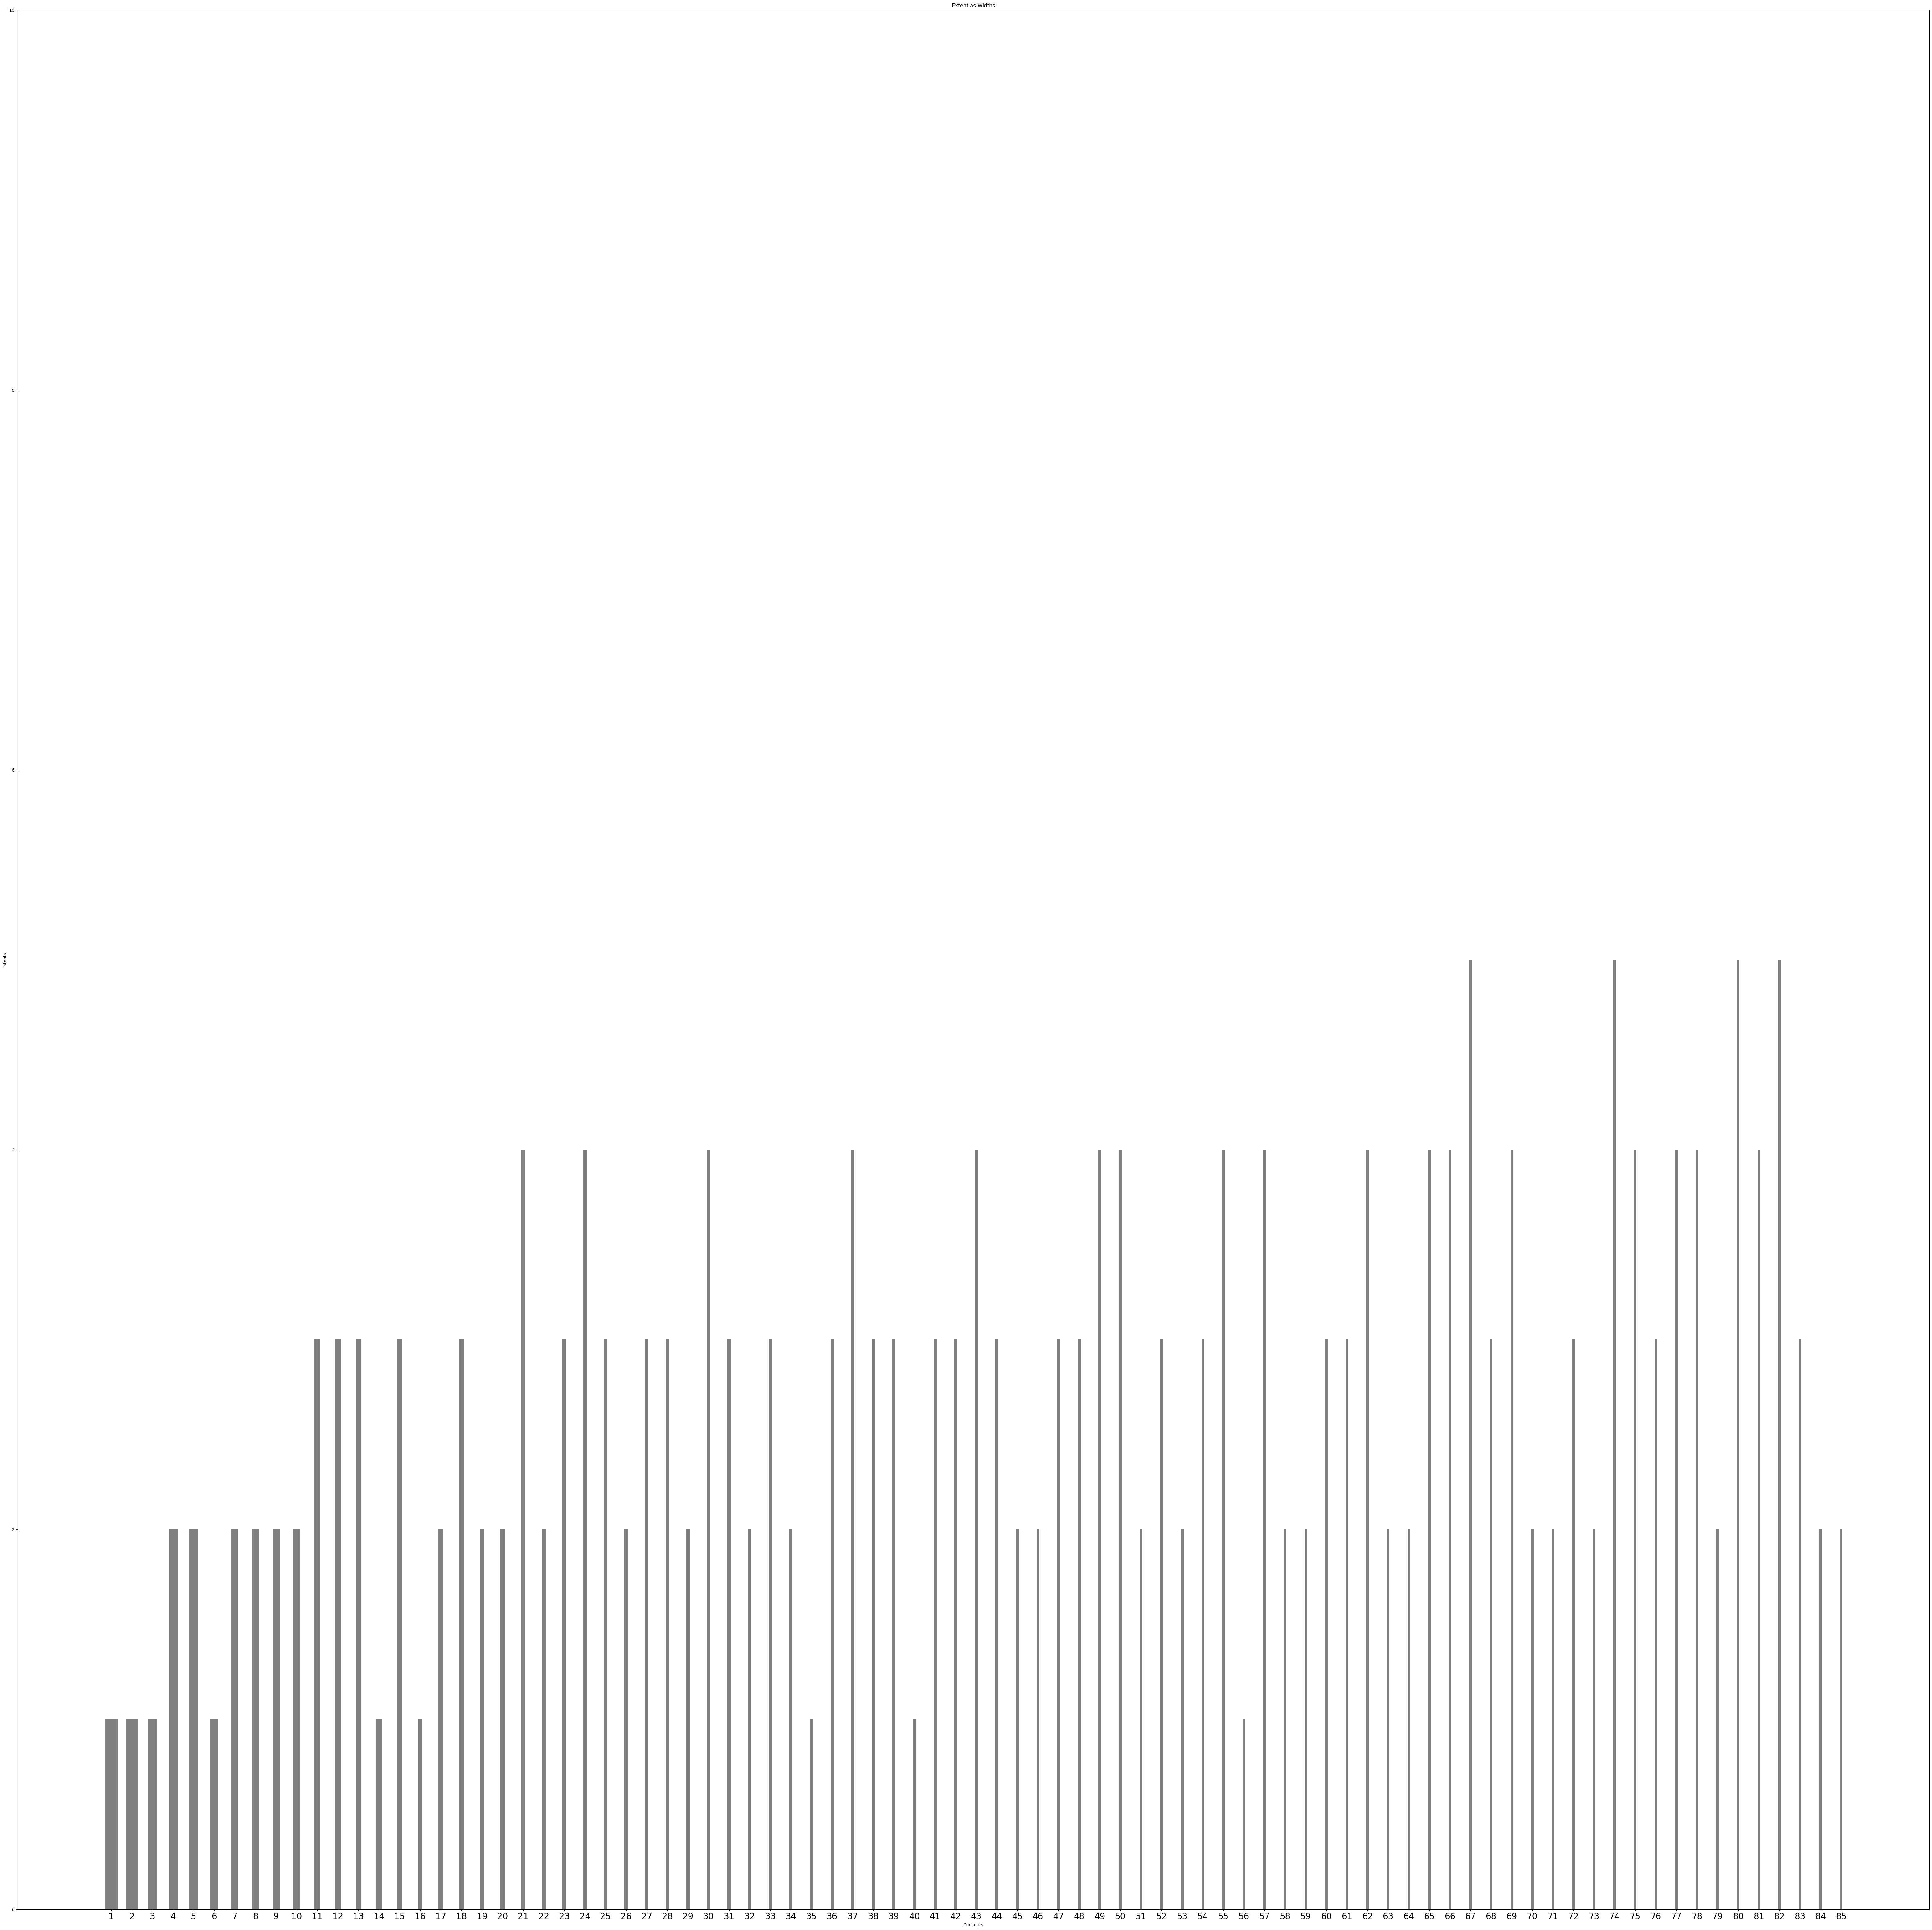

In [182]:
import numpy as np

values = y_coords
widths = x_coords  # Proportional widths

# Normalize the widths to fit within a maximum space
max_width = 1.0
normalized_widths = [w / max(widths) * max_width for w in widths]
print(normalized_widths)
# Calculate the positions of the bar centers
num_bars = len(values)
spacing = 1.5  # Equal spacing between centers
positions = np.arange(num_bars) * spacing

# Plot the bars
fig, ax = plt.subplots(figsize=(80, 80))

for i in range(num_bars):
    ax.bar(positions[i], values[i], width=normalized_widths[i], align='center', color='gray')

# Set x-ticks to be in the center of the bars
ax.set_xticks(positions)
ax.set_xticklabels([i for i in indices], fontsize=20)
ax.set_ylim(0, 10)
plt.xlabel('Concepts')
plt.ylabel('Intents')
plt.title('Extent as Widths')

plt.show()

In [184]:
# Plot the bars
fig, ax = plt.subplots(figsize=(80,80))

for i in range(num_bars):
    ax.bar(positions[i], values[i], width=normalized_widths[i], align='center', color='gray')

# Set x-ticks to be in the center of the bars
ax.set_xticks(positions)
ax.set_xticklabels([i for i in indices], fontsize=20)

# Hide the axes spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove the y-axis labels
ax.set_yticklabels([])
ax.set_ylim(0, 10)
# Optionally, you can also remove the y-axis ticks if desired
ax.yaxis.set_ticks_position('none')

plt.savefig('../results/barchart/to_compare.png')
plt.close()

In [186]:
# plot without grid and labels
# Plot the bars
fig, ax = plt.subplots(figsize=(80, 80))

for i in range(num_bars):
    ax.bar(positions[i], values[i], width=normalized_widths[i], align='center', color='gray')
ax.set_ylim(0, 10)
ax.axis('off')
plt.savefig('../results/barchart/to_process.png')
plt.close()

## Saliency Mapping

We choose 3 methods: Vanilla Integrated gradient, Smooth Integrated Gradient and XRAI Heatmap.

In [6]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
from PIL import Image, ImageEnhance

import saliency.core as saliency


### Utility methods

In [1]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im)
  plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
  plt.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im, cmap='inferno')
  plt.title(title)

def LoadImage(file_path):
    im = Image.open(file_path).convert('RGB')
    
    # # Resize while maintaining aspect ratio
    # im.thumbnail((224, 224), Image.Resampling.LANCZOS)
    
    # # Create a new image with the target size and a white background
    # new_im = Image.new('RGB', (224, 224), (255, 255, 255))
    
    # # Paste the resized image onto the center of the new image
    # new_im.paste(im, ((224 - im.width) // 2, (224 - im.height) // 2))
    
    # im = np.asarray(new_im)
    im = im.resize((224,224))
    im = np.asarray(im)
    return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

In [189]:
m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
conv_layer = m.get_layer('block5_conv3')
model = tf.keras.models.Model(inputs=m.input, outputs=[conv_layer.output, m.output])

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [5]:
charts = ['lattice', 'scatterplot', 'barchart']
percentages = [1, 50, 100]

for chart in charts:
# Load the image
    im_orig = LoadImage(f'../results/{chart}/to_process.png')
    im = PreprocessImage(im_orig)

    # Show the image
    ShowImage(im_orig)

    _, predictions = model(np.array([im]))
    prediction_class = np.argmax(predictions[0])
    call_model_args = {class_idx_str: prediction_class}

    print("Prediction class: " + str(prediction_class))

NameError: name 'LoadImage' is not defined

We create a function that computes images based on percentages.

In [191]:
def compute_pecentile(im_origin, perc, saliency_mask):
    total = 100
    mask = saliency_mask >= np.percentile(saliency_mask, total-perc)
    im_mask = np.array(im_origin)
    im_mask[~mask] = 0
    return im_mask

### Vanilla Integrated gradient

<Figure size 1000x1000 with 0 Axes>

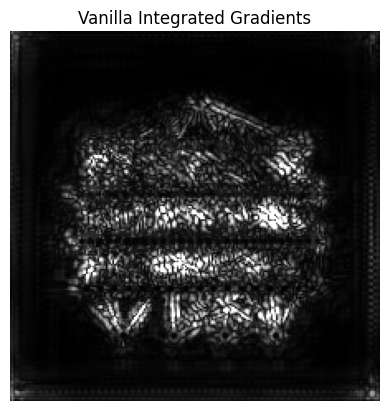

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

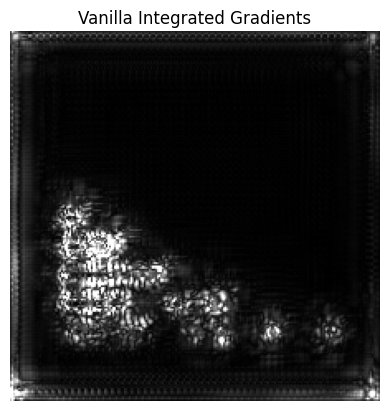

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

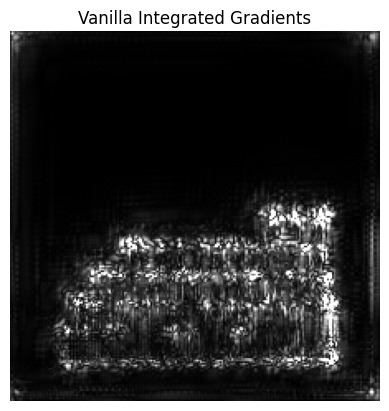

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [192]:
for chart in charts:
# Load the image
    im_orig = LoadImage('../results/'+chart+'/to_process.png')
    im = PreprocessImage(im_orig)

    # Set up matplot lib figure
    plt.figure(figsize=figsize)

    # Construct the saliency object
    integrated_gradients = saliency.IntegratedGradients()

    # Baseline is a black image.
    baseline = np.zeros(im.shape)

    # compute mask
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    integrated_vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)

    # Render the saliency masks.
    ShowGrayscaleImage(integrated_vanilla_mask_grayscale, title='Vanilla Integrated Gradients')

    plt.savefig(f'../results/{chart}/vanilla_integrated_grad.png', bbox_inches='tight', pad_inches=0)

    for perc in percentages:
        plt.figure(figsize=figsize)
        new_mask = compute_pecentile(im_orig, perc, integrated_vanilla_mask_grayscale)
        ShowImage(new_mask)
        plt.savefig(f'../results/{chart}/VIG_top_{str(perc)}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

### Smooth Integrated Gradient

<Figure size 1000x1000 with 0 Axes>

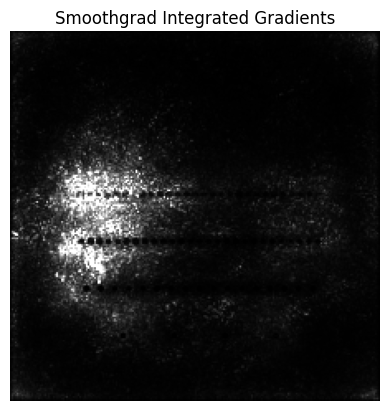

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

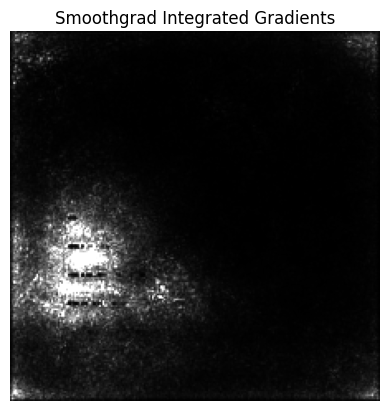

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

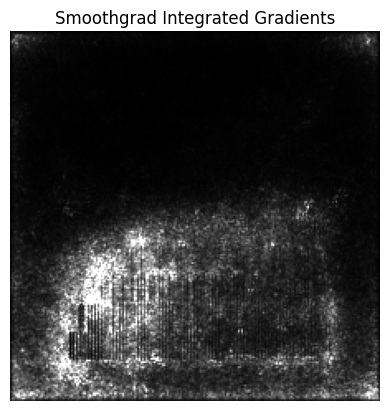

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [193]:
for chart in charts:
# Load the image
    im_orig = LoadImage('../results/'+chart+'/to_process.png')
    im = PreprocessImage(im_orig)

    # Set up matplot lib figure
    plt.figure(figsize=figsize)

    # Construct the saliency object
    integrated_gradients = saliency.IntegratedGradients()

    # Baseline is a black image.
    baseline = np.zeros(im.shape)

    # compute mask
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

    # Render the saliency masks.
    ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients')

    plt.savefig(f'../results/{chart}/smooth_integrated_grad.png', bbox_inches='tight', pad_inches=0)

    for perc in percentages:
        plt.figure(figsize=figsize)
        new_mask = compute_pecentile(im_orig, perc, smoothgrad_mask_grayscale)
        ShowImage(new_mask)
        plt.savefig(f'../results/{chart}/SIG_top_{str(perc)}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

### XRAI Heatmap

<Figure size 1000x1000 with 0 Axes>

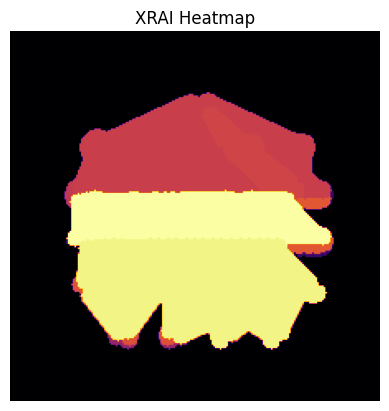

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

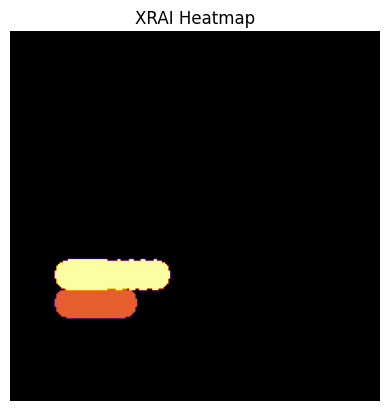

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

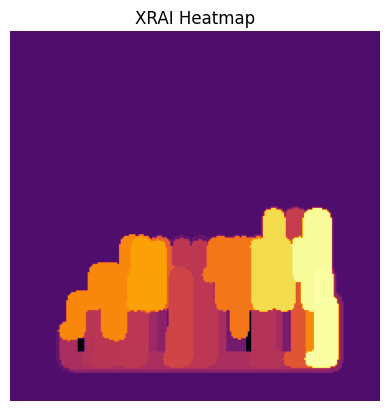

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [211]:
for chart in charts:
# Load the image
    im_orig = LoadImage('../results/'+chart+'/to_process.png')
    im = PreprocessImage(im_orig)

    # Set up matplot lib figure
    plt.figure(figsize=figsize)

    # Construct the saliency object
    xrai_object = saliency.XRAI()

    # compute mask
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

    # Render the saliency mask
    ShowHeatMap(xrai_attributions, title='XRAI Heatmap')

    plt.savefig(f'../results/{chart}/xray.png', bbox_inches='tight', pad_inches=0)

    for perc in percentages:
        plt.figure(figsize=figsize)
        new_mask = compute_pecentile(im_orig, perc, xrai_attributions)
        ShowImage(new_mask)
        plt.savefig(f'../results/{chart}/XRAY_top_{str(perc)}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

### Compare Input and Output Images

In [17]:
saliency_methods = ['VIG', 'SIG', 'XRAY']
charts = ['lattice', 'scatterplot', 'barchart']
percentages = [1, 50, 100]
for chart in charts:
    input_image = Image.open(f'../results/{chart}/to_compare.png')
    for method in saliency_methods:
        for perc in percentages:
            output_image = Image.open(f'../results/{chart}/{method}_top_{str(perc)}.png')

            # Resize the input image to match the dimensions of the output image
            input_image_resized = input_image.resize(output_image.size, Image.Resampling.LANCZOS)

            # Convert both images to RGBA
            input_image_resized = input_image_resized.convert('RGBA')
            output_image = output_image.convert('RGBA')

            # Enhance the visibility of the output image by adjusting its contrast (if needed)
            enhancer = ImageEnhance.Contrast(output_image)
            output_image = enhancer.enhance(3.0)

            # Create a blended image for visualization
            blended_image = Image.blend(input_image_resized, output_image, alpha=0.2)

            # Display the blended image
            fig, ax = plt.subplots(figsize=figsize)

            ax.imshow(blended_image)
            ax.axis('off')


            plt.savefig(f'../results/{chart}/{method}_overaly_{str(perc)}_percent.png', bbox_inches='tight')
            plt.close()

## Data Analysis

I will collect and analyse results grouping them by saliency algorithm.

1. Vanilla Intergated Gradient (VIG):
   1. barchart: visually, results are not significant since 1% has spots in all the peaks of the bars, and 50% includes almost all bars.
   2. lattice: visually, edges seem to have attracted more attention than nodes. Since in the 1% no nodes are higlighted, I will consider all the nodes that have a edge higlighted (both ways) if the node is not exluded in the 50%. For the 100% I will consider all those nodes that are not included in the 50% and don't have and edge in the 1%.
   3. scatterplot: For the 1%, I will consider data points that have white around them. Since there is no difference between 50% and 100%, for the 100% I will consider data points that in 1% are not involved at all.
2. Smoothed Integrated Gradient  (SIG):
   1. barchart: visually, results are more significant than VIG. For 1% I will take all the bars whose peaks have a cluster of focus. For the 100% I will take bars that either are black or have more than 3 black notches.
   2. lattice: visually, the algorithm  seems effective in its results, the focus is both on nodes and edges. As with VIG, I will consider all the nodes that have a edge higlighted (both ways) if the node is not exluded in the 50%, and highlighted nodes as well. For the 100%, there are clear blockings in the 50%: upper right, center of the bottom line, center-right of the line above and so on. Since there are many, I will choose the most evident ones.
   3. scatterplot: visually, there is not much of a difference with VIG, the algorithm seemed to have avoided nodes. However, in a few cases nodes are more clearly surrounded and there is difference between 50% and 100%. So for the 1% I will take the nodes thet are clearly highlighted.
3. XRAY:
   1. barchart: visually, the heatmap presents a high level of variety. The 1% is very clear, since there are several bars that are highlighted for the most part. However, I will not include those which have only a small portion. For the 100% I will take into consideration all the bars that in the 50% have a black portion, since there are not many.
   2. lattice: visually, there is a clear division in levels, even though they don't follow a straight downword increase/decrease in importance. For the 1% i will include all nodes that are clearly highlighted. Between 50% and 100% there is no difference. Looking at the full heatmap, for the 100% I will take nodes in the most dark area, the red one.
   3. scatterplot: visually, focus areas are very clear. For 1% I will take all the third row. Since there is no difference between 50% and 100%, for the 100% I will take data point that are not visible at all in the heatmap.

The outputs of this data collection are 3 files named `{method}_results.json` in the results folder.


Now we need to prepare data in results to be used in the user survey.
For each methos, we will output 2 files:
- `../results/{method}_results_metadata.json`: organised by visulisation type, contains all the top concepts and the bottom concepts with information about concet id, number of attributes, attribute labels, number of artworks and their percentage with respect to the total.
- `../results/{method}_salient_concepts_summary.json`: for each visulisation type, we store information about top/bottom number of concepts and their labels.

In [3]:
import json

saliency_methods = ['VIG', 'SIG', 'XRAY']
charts = ['lattice', 'scatterplot', 'barchart']
total_artworks = 58800

In [5]:
for method in saliency_methods:
    saliency_results = f'../results/{method}_results.json'

    saliency_results_metadata_file = f'../results/{method}_results_metadata.json'

    salient_concepts_summary_file = f'../results/{method}_salient_concepts_summary.json'

    saliency_results_metadata = {}

    salient_concepts_summary = {}

    with open(saliency_results, 'r') as file:
        data = json.load(file)

    for chart in charts:
        chart_dict = {}
        chart_summary = {}
        if data[chart]['01']:
            one_percent_concepts = data[chart]['01']
            one_percent_dicts_list = []
            one_percent_summary = {}
            one_percent_summary['concepts_num'] = len(one_percent_concepts)
            one_percent_summary_labels = []
            for c in one_percent_concepts:
                concept_dict = {}
                concept_dict['id'] = c
                concept_dict['attributes_num'] = len(L[c].intent)
                concept_dict['attributes'] = L[c].intent
                concept_dict['artworks_num'] = len(L[c].extent)
                concept_dict['saliency'] = 'top'
                percentage = (len(L[c].extent) / total_artworks) * 100
                rounded_percentage = round(percentage, 2)
                concept_dict['artworks_percentage'] = rounded_percentage
                # concept_dict['artworks'] = L[c].extent
                one_percent_dicts_list.append(concept_dict)
                one_percent_summary_labels.append(str(tuple(L[c].intent)))
                # alternative
                # one_percent_summary_labels[c] = L[c].intent
            chart_dict['01'] = one_percent_dicts_list
            one_percent_summary['labels'] = one_percent_summary_labels
            chart_summary['01'] = one_percent_summary
        if data[chart]['100']:
            hundred_percent_concepts = data[chart]['100']
            hundred_percent_dicts_list = []
            hundred_percent_summary = {}
            hundred_percent_summary['concepts_num'] = len(hundred_percent_concepts)
            hundred_percent_summary_labels = []
            for c in hundred_percent_concepts:
                concept_dict = {}
                concept_dict['id'] = c
                concept_dict['attributes_num'] = len(L[c].intent)
                concept_dict['attributes'] = L[c].intent
                concept_dict['artworks_num'] = len(L[c].extent)
                concept_dict['saliency'] = 'bottom'
                percentage = (len(L[c].extent) / total_artworks) * 100
                rounded_percentage = round(percentage, 2)
                concept_dict['artworks_percentage'] = rounded_percentage
                # concept_dict['artworks'] = L[c].extent
                hundred_percent_dicts_list.append(concept_dict)
                hundred_percent_summary_labels.append(str(tuple(L[c].intent)))
            chart_dict['100'] = hundred_percent_dicts_list
            hundred_percent_summary['labels'] = hundred_percent_summary_labels
            chart_summary['100'] = hundred_percent_summary
        saliency_results_metadata[chart] = chart_dict
        salient_concepts_summary[chart] = chart_summary

    
    with open(saliency_results_metadata_file, 'w') as file:
        json.dump(saliency_results_metadata, file)

    with open(salient_concepts_summary_file, 'w') as file:
        json.dump(salient_concepts_summary, file)


Starting from `../results/{method}_results_metadata.json`, we create two files (`../a_group_data.json` and `../b_group_data.json`), to store all the top/bottom pairs to show in the user survey. Files are organised by combination method-vis_type.

In [7]:
import itertools
import random

max_pairs_threshold = 50

a_group_data_file = '../a_group_data.json'
b_group_data_file = '../b_group_data.json'

a_group_data = {}
b_group_data = {}

# function to make dictionaries hashable by converting to tuple of sorted key-value pairs
def make_hashable(d):
    return tuple(sorted((k, tuple(v) if isinstance(v, list) else v) for k, v in d.items()))

for method in saliency_methods:
    a_group_data[method] = {}
    b_group_data[method] = {}
    saliency_results_metadata_file = f'../results/{method}_results_metadata.json'

    with open(saliency_results_metadata_file, 'r') as file:
        method_saliency_data = json.load(file)

        for chart in charts:
            a_group_data[method][chart] = {}
            b_group_data[method][chart]  = {}
            # be sure there are result for the chart
            if len(method_saliency_data[chart]) > 0:
                # count the number of concepts for top 1 and bottom 100
                top_concepts = method_saliency_data[chart]['01']
                len_top = len(top_concepts)
                bottom_concepts = method_saliency_data[chart]['100']
                len_bottom = len(bottom_concepts)
                # max number of combinations we can test top x bottom
                max_num_combinations = len_top * len_bottom

                # randomly rearrange the content of the two lists before creating combinations to avoid biases in data collection
                random.shuffle(top_concepts)
                random.shuffle(bottom_concepts)

                # Initialize an empty list to store the combinations
                combinations_list = []

                # we know for sure that we have one case in which we can't reach max_pairs_threshold combinations
                if max_num_combinations <= max_pairs_threshold:
                    # simply create combinations of everything
                    combinations = itertools.product(top_concepts, bottom_concepts)
                    combinations_list = list(combinations)
                    

                else:
                    # we make sure that each concept appears at least once in the 50 combinations we want to create
                    # make sure the loop runs enough times to cover the longer list
                    for i in range(max(len(top_concepts), len(bottom_concepts))):
                        if i < len(top_concepts):
                            pair = [top_concepts[i], bottom_concepts[i % len(bottom_concepts)]]
                            combinations_list.append(tuple(pair))
                        if i < len(bottom_concepts):
                            pair = [top_concepts[i % len(top_concepts)], bottom_concepts[i]]
                            combinations_list.append(tuple(pair))

                    # convert dictionaries to tuples of frozensets to make them hashable and remove duplicates
                    unique_combinations = set((make_hashable(pair[0]), make_hashable(pair[1])) for pair in combinations_list)

                    # convert back to list of dictionaries
                    combinations_list = [(dict(pair[0]), dict(pair[1])) for pair in unique_combinations][:max_pairs_threshold]

                    # if there are still less than max_pairs_threshold combinations, generate additional random combinations
                    while len(combinations_list) < max_pairs_threshold:
                        combination = (random.choice(top_concepts), random.choice(bottom_concepts))
                        combo_tuple = (make_hashable(combination[0]), make_hashable(combination[1]))
                        if combo_tuple not in unique_combinations:
                            unique_combinations.add(combo_tuple)
                            combinations_list.append((combination[0], combination[1]))  
                
                # we need to avoid having the top salient concept always as first element.
                # Initialize an empty list to store the randomized combinations
                randomized_combinations_list = []
                for pair in combinations_list:
                    pair_list = list(pair)
                    random.shuffle(pair_list)
                    randomized_combinations_list.append(tuple(pair_list))

                combinations_list = randomized_combinations_list
                # split in half to assign to two different groups
                length_combinations = len(combinations_list)
                length_half_combinations = length_combinations//2
                first_half_combinations = combinations_list[:length_half_combinations]
                second_half_combinations = combinations_list[length_half_combinations:]

                # add to group dictionaries and files
                a_group_data[method][chart] = first_half_combinations
                b_group_data[method][chart] = second_half_combinations

with open(a_group_data_file, 'w') as file:
    json.dump(a_group_data, file)

with open(b_group_data_file, 'w') as file:
    json.dump(b_group_data, file)
